# Vehicle Insurance Fraud Detection
## Predictive Optimization Analytics CAT 1
**Student:** Kevin Obote - 190696

### Introduction
Vehicle insurance fraud involves conspiring to file false or exaggerated claims related to property damage or personal injuries. This project aims to develop a predictive model optimized to identify potential fraudulent cases. We will follow a structured data science workflow:

1.  **Data Preprocessing:** Cleaning, encoding, scaling, and handling class imbalance.
2.  **Model Training:** Decision Trees, Ensemble Models (Random Forest, Gradient Boosting), and Artificial Neural Networks (ANN).
3.  **Optimization:** Hyperparameter tuning using Validation Curves and RandomizedSearchCV.
4.  **Evaluation:** Using Accuracy and F1-score, specifically addressing the class imbalance with SMOTE.

**Objective:** Develop a robust classifier to detect `FraudFound_P`.

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Scikit-learn modules
from sklearn.model_selection import train_test_split, cross_val_score, validation_curve, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, confusion_matrix, f1_score, accuracy_score
from sklearn.feature_selection import RFE

# Imbalanced learning
from imblearn.over_sampling import SMOTE

# Model persistence
import joblib

# Warnings
import warnings
warnings.filterwarnings('ignore')

### Step 1: Data Preprocessing
We will load the dataset and prepare it for modeling. This involves cleaning, encoding categorical variables, and handling the significant class imbalance present in fraud datasets.

In [2]:
# Load the dataset
url = "https://raw.githubusercontent.com/NUELBUNDI/Machine-Learning-Data-Set/refs/heads/main/Insurance%20Fraud%20data.csv"
df = pd.read_csv(url)

# Display the shape of the dataset
print("Dataset Shape:", df.shape)

Dataset Shape: (15420, 33)


In [3]:
# Display target variable distribution
print("\nTarget Distribution:")
print(df['FraudFound_P'].value_counts())



Target Distribution:
FraudFound_P
0    14497
1      923
Name: count, dtype: int64


In [4]:
# Display first few rows
df.head()

,Month,WeekOfMonth,DayOfWeek,Make,AccidentArea,DayOfWeekClaimed,MonthClaimed,WeekOfMonthClaimed,Sex,MaritalStatus,...,AgeOfVehicle,AgeOfPolicyHolder,PoliceReportFiled,WitnessPresent,AgentType,NumberOfSuppliments,AddressChange_Claim,NumberOfCars,Year,BasePolicy
0,Dec,5,Wednesday,Honda,Urban,Tuesday,Jan,1,Female,Single,...,3 years,26 to 30,No,No,External,none,1 year,3 to 4,1994,Liability
1,Jan,3,Wednesday,Honda,Urban,Monday,Jan,4,Male,Single,...,6 years,31 to 35,Yes,No,External,none,no change,1 vehicle,1994,Collision
2,Oct,5,Friday,Honda,Urban,Thursday,Nov,2,Male,Married,...,7 years,41 to 50,No,No,External,none,no change,1 vehicle,1994,Collision
3,Jun,2,Saturday,Toyota,Rural,Friday,Jul,1,Male,Married,...,more than 7,51 to 65,Yes,No,External,more than 5,no change,1 vehicle,1994,Liability
4,Jan,5,Monday,Honda,Urban,Tuesday,Feb,2,Female,Single,...,5 years,31 to 35,No,No,External,none,no change,1 vehicle,1994,Collision


In [5]:
# Display columns
df.columns

Index(['Month', 'WeekOfMonth', 'DayOfWeek', 'Make', 'AccidentArea',
       'DayOfWeekClaimed', 'MonthClaimed', 'WeekOfMonthClaimed', 'Sex',
       'MaritalStatus', 'Age', 'Fault', 'PolicyType', 'VehicleCategory',
       'VehiclePrice', 'FraudFound_P', 'PolicyNumber', 'RepNumber',
       'Deductible', 'DriverRating', 'Days_Policy_Accident',
       'Days_Policy_Claim', 'PastNumberOfClaims', 'AgeOfVehicle',
       'AgeOfPolicyHolder', 'PoliceReportFiled', 'WitnessPresent', 'AgentType',
       'NumberOfSuppliments', 'AddressChange_Claim', 'NumberOfCars', 'Year',
       'BasePolicy'],
      dtype='object')

In [6]:
# Data types
df.dtypes

Month                   object
WeekOfMonth              int64
DayOfWeek               object
Make                    object
AccidentArea            object
DayOfWeekClaimed        object
MonthClaimed            object
WeekOfMonthClaimed       int64
Sex                     object
MaritalStatus           object
Age                      int64
Fault                   object
PolicyType              object
VehicleCategory         object
VehiclePrice            object
FraudFound_P             int64
PolicyNumber             int64
RepNumber                int64
Deductible               int64
DriverRating             int64
Days_Policy_Accident    object
Days_Policy_Claim       object
PastNumberOfClaims      object
AgeOfVehicle            object
AgeOfPolicyHolder       object
PoliceReportFiled       object
WitnessPresent          object
AgentType               object
NumberOfSuppliments     object
AddressChange_Claim     object
NumberOfCars            object
Year                     int64
BasePoli

In [7]:
# Check the rows of column 'PolicyNumber'
df['PolicyNumber'].head()

0    1
1    2
2    3
3    4
4    5
Name: PolicyNumber, dtype: int64

In [8]:
# Check the rows of column 'RepNumber'
df['RepNumber'].head()

0    12
1    15
2     7
3     4
4     3
Name: RepNumber, dtype: int64

#### a. Data Cleaning
- **Missing Values:** We check for nulls. The dataset is generally clean, but verification is required.
- **Irrelevant Features:** `PolicyNumber` and `RepNumber` are unique identifiers that do not carry predictive signal and can cause overfitting, so they are dropped.

In [9]:
# Check for missing values
if df.isnull().sum().sum() == 0:
    print("No missing values found.")
else:
    print(df.isnull().sum())

No missing values found.


In [10]:
# Detailed missing value report
null_counts = df.isnull().sum()
null_percent = (df.isnull().sum() / len(df)) * 100

missing_data = pd.concat([null_counts, null_percent], axis=1, keys=['Total', 'Percent'])
missing_data = missing_data[missing_data['Total'] > 0].sort_values(by='Total', ascending=False)

if missing_data.empty:
    print("Clean sweep! No missing values found.")
else:
    print("Missing values detected:")
    print(missing_data)

Clean sweep! No missing values found.


In [11]:
# Drop identifiers
df = df.drop(['PolicyNumber', 'RepNumber'], axis=1)
print("Dropped PolicyNumber and RepNumber.")

Dropped PolicyNumber and RepNumber.


In [ ]:
# Check outliers


#### b. Feature Encoding
Most features in this dataset are categorical (e.g., `Make`, `AccidentArea`, `Sex`). Machine learning models require numerical input.
- We use **Label Encoding** for categorical features. While One-Hot Encoding is an alternative, Label Encoding keeps the dimensionality low, which is beneficial given the number of categorical columns.

In [12]:
le = LabelEncoder()
categorical_cols = df.select_dtypes(include=['object']).columns

for col in categorical_cols:
    df[col] = le.fit_transform(df[col])

In [13]:
print("Data after Label Encoding:")
df.head()

Data after Label Encoding:


,Month,WeekOfMonth,DayOfWeek,Make,AccidentArea,DayOfWeekClaimed,MonthClaimed,WeekOfMonthClaimed,Sex,MaritalStatus,...,AgeOfVehicle,AgeOfPolicyHolder,PoliceReportFiled,WitnessPresent,AgentType,NumberOfSuppliments,AddressChange_Claim,NumberOfCars,Year,BasePolicy
0,2,5,6,6,1,6,5,1,0,2,...,1,3,0,0,0,3,0,2,1994,2
1,4,3,6,6,1,2,5,4,1,2,...,4,4,1,0,0,3,3,0,1994,1
2,10,5,0,6,1,5,10,2,1,1,...,5,6,0,0,0,3,3,0,1994,1
3,6,2,2,17,0,1,6,1,1,1,...,6,7,1,0,0,2,3,0,1994,2
4,4,5,1,6,1,6,4,2,0,2,...,3,4,0,0,0,3,3,0,1994,1


#### c. Feature Selection (Correlation Analysis)
We analyze the correlation matrix to see which features relate most strongly to `FraudFound_P`.

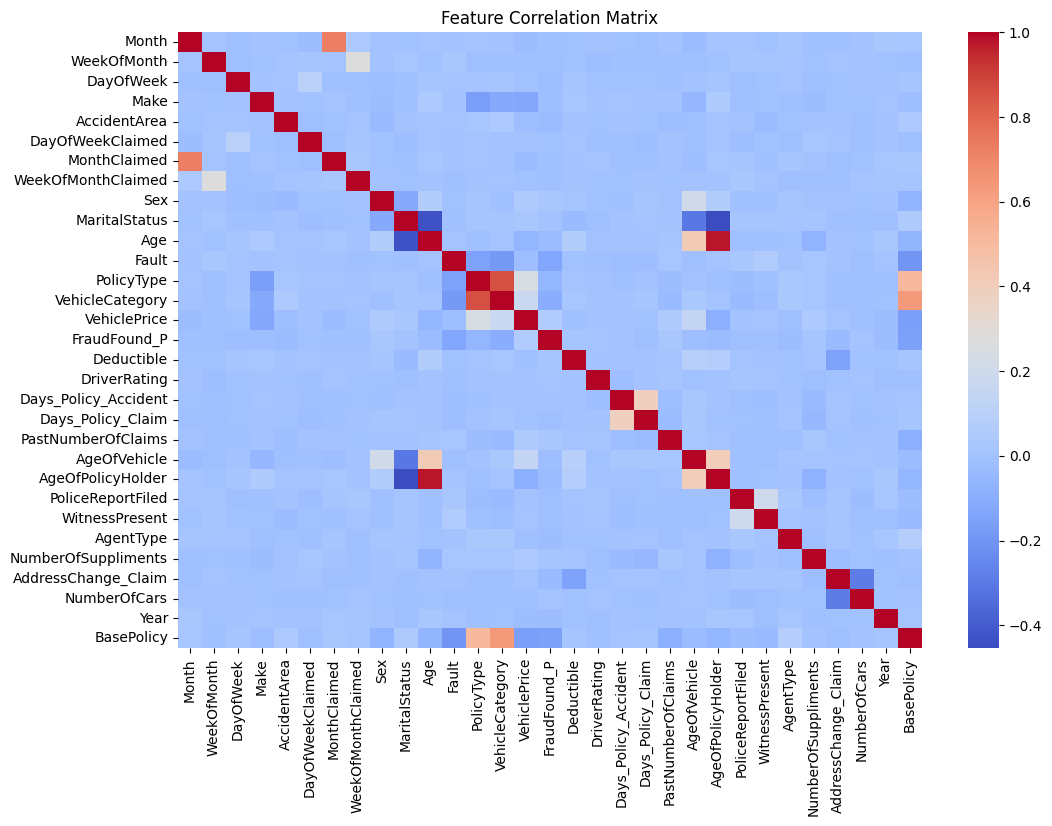

In [14]:
plt.figure(figsize=(12, 8))
sns.heatmap(df.corr(), cmap='coolwarm', annot=False)
plt.title("Feature Correlation Matrix")
plt.show()

In [15]:
# Top correlations with target
print("Top 5 features correlated with FraudFound_P:")
print(df.corr()['FraudFound_P'].abs().sort_values(ascending=False).head(6))

Top 5 features correlated with FraudFound_P:
FraudFound_P       1.000000
BasePolicy         0.157079
Fault              0.131389
VehicleCategory    0.099198
VehiclePrice       0.061541
PolicyType         0.057057
Name: FraudFound_P, dtype: float64


#### d. Handling Imbalance (SMOTE) & Scaling
The dataset is highly imbalanced (few fraud cases). We use **SMOTE (Synthetic Minority Over-sampling Technique)** to generate synthetic examples of the minority class.

**Crucial Step:** We split the data *before* applying SMOTE. We only oversample the **training data** to prevent data leakage. The test set remains realistic (imbalanced).

We also apply **StandardScaler** to normalize features, which is essential for the ANN and helpful for other models.

In [16]:
# Calculate counts and percentages
counts = df['FraudFound_P'].value_counts()
percentages = df['FraudFound_P'].value_counts(normalize=True) * 100

print("--- Class Distribution ---")
print(counts)
print("\n--- Percentage Breakdown ---")
print(percentages)

--- Class Distribution ---
FraudFound_P
0    14497
1      923
Name: count, dtype: int64

--- Percentage Breakdown ---
FraudFound_P
0    94.014267
1     5.985733
Name: proportion, dtype: float64


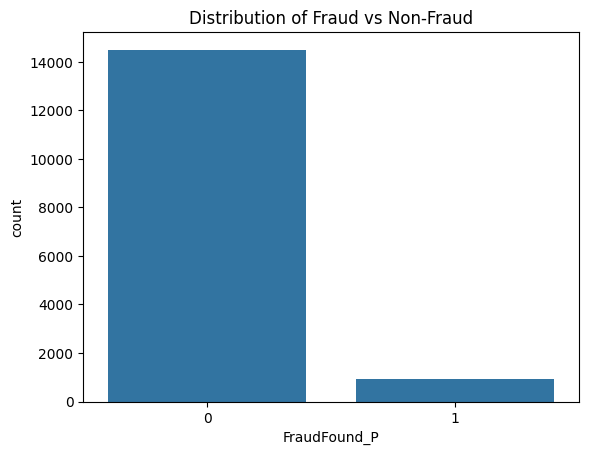

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(x='FraudFound_P', data=df)
plt.title('Distribution of Fraud vs Non-Fraud')
plt.show()

In [18]:
X = df.drop('FraudFound_P', axis=1)
y = df['FraudFound_P']

# Split Data (80% Train, 20% Test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Apply SMOTE to Training Data ONLY
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

print(f"Original Train counts: {y_train.value_counts().to_dict()}")
print(f"Resampled Train counts: {y_train_res.value_counts().to_dict()}")

# Scaling
scaler = StandardScaler()
X_train_res = scaler.fit_transform(X_train_res)
X_test = scaler.transform(X_test)

Original Train counts: {0: 11598, 1: 738}
Resampled Train counts: {0: 11598, 1: 11598}


### Step 2: Train a Decision Tree Classifier
We train a baseline Decision Tree. Since we balanced the training data, we can look at Accuracy, but we will also monitor F1-score.

In [19]:
dt = DecisionTreeClassifier(random_state=42)
dt.fit(X_train_res, y_train_res)

y_pred_dt = dt.predict(X_test)

print("--- Decision Tree Results ---")
print("Accuracy:", accuracy_score(y_test, y_pred_dt))
print("F1 Score:", f1_score(y_test, y_pred_dt))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred_dt))

--- Decision Tree Results ---
Accuracy: 0.8557068741893644
F1 Score: 0.1834862385321101

Confusion Matrix:
 [[2589  310]
 [ 135   50]]


### Step 3: Optimize Decision Tree Hyperparameters
Decision Trees are prone to overfitting. We use a **Validation Curve** to find the optimal `max_depth`.

In [20]:
param_range = range(1, 21)
train_scores, test_scores = validation_curve(
    DecisionTreeClassifier(random_state=42),
    X_train_res, y_train_res,
    param_name="max_depth",
    param_range=param_range,
    scoring="accuracy",
    n_jobs=-1,
    cv=5
)

train_mean = np.mean(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)

plt.figure(figsize=(10, 6))
plt.plot(param_range, train_mean, label="Training score", color="darkorange")
plt.plot(param_range, test_mean, label="Cross-validation score", color="navy")
plt.title("Validation Curve: Decision Tree Max Depth")
plt.xlabel("Max Depth")
plt.ylabel("Accuracy")
plt.legend(loc="best")
plt.show()

# Select best depth (argmax of test score)
best_depth = param_range[np.argmax(test_mean)]
print(f"Optimal Max Depth: {best_depth}")

# Retrain
dt_opt = DecisionTreeClassifier(max_depth=best_depth, random_state=42)
dt_opt.fit(X_train_res, y_train_res)
print("Optimized DT Accuracy:", accuracy_score(y_test, dt_opt.predict(X_test)))

Exception ignored deletion of interned string failed:
Traceback (most recent call last):
  File "<frozen importlib._bootstrap>", line 688, in _load_unlocked
KeyError: 'max_seq_items'
Fatal Python error: Segmentation fault

Current thread 0x00007f0868947600 (most recent call first):
  Garbage-collecting
  File "/home/obote/anaconda3/envs/ml_env/lib/python3.10/abc.py", line 24 in abstractmethod
  File "/home/obote/anaconda3/envs/ml_env/lib/python3.10/site-packages/pandas/core/strings/base.py", line 71 in BaseStringArrayMethods
  File "/home/obote/anaconda3/envs/ml_env/lib/python3.10/site-packages/pandas/core/strings/base.py", line 21 in <module>
  File "<frozen importlib._bootstrap>", line 241 in _call_with_frames_removed
  File "<frozen importlib._bootstrap_external>", line 883 in exec_module
  File "<frozen importlib._bootstrap>", line 688 in _load_unlocked
  File "<frozen importlib._bootstrap>", line 1006 in _find_and_load_unlocked
  File "<frozen importlib._bootstrap>", line 1027 in 

TerminatedWorkerError: A worker process managed by the executor was unexpectedly terminated. This could be caused by a segmentation fault while calling the function or by an excessive memory usage causing the Operating System to kill the worker.

The exit codes of the workers are {SIGSEGV(-11)}
Detailed tracebacks of the workers should have been printed to stderr in the executor process if faulthandler was not disabled.

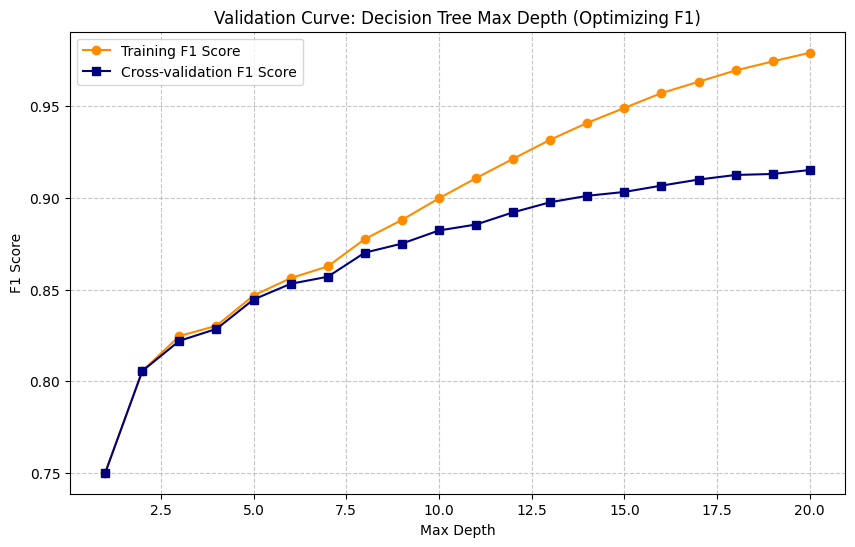

Optimal Max Depth: 20

--- Optimized Decision Tree Results (Depth=20) ---
Accuracy: 0.8446822308690013
F1 Score: 0.1949579831932773

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.88      0.91      2899
           1       0.14      0.31      0.19       185

    accuracy                           0.84      3084
   macro avg       0.55      0.60      0.55      3084
weighted avg       0.90      0.84      0.87      3084



In [21]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import validation_curve
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, f1_score

param_range = range(1, 21)

# Using n_jobs=1 to prevent the Segmentation Fault (Segfault)
# Using scoring="f1" because accuracy is misleading for imbalanced fraud data
train_scores, test_scores = validation_curve(
    DecisionTreeClassifier(random_state=42),
    X_train_res, y_train_res,
    param_name="max_depth",
    param_range=param_range,
    scoring="f1", 
    n_jobs=1,
    cv=5
)

train_mean = np.mean(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)

# Visualization
plt.figure(figsize=(10, 6))
plt.plot(param_range, train_mean, label="Training F1 Score", color="darkorange", marker='o')
plt.plot(param_range, test_mean, label="Cross-validation F1 Score", color="navy", marker='s')
plt.title("Validation Curve: Decision Tree Max Depth (Optimizing F1)")
plt.xlabel("Max Depth")
plt.ylabel("F1 Score")
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(loc="best")
plt.show()

# Select best depth based on the highest validation F1 score
best_depth = param_range[np.argmax(test_mean)]
print(f"Optimal Max Depth: {best_depth}")

# Retrain with the optimal depth
dt_opt = DecisionTreeClassifier(max_depth=best_depth, random_state=42)
dt_opt.fit(X_train_res, y_train_res)

# Evaluate
y_pred = dt_opt.predict(X_test)
print(f"\n--- Optimized Decision Tree Results (Depth={best_depth}) ---")
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
print(f"F1 Score: {f1_score(y_test, y_pred)}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

### Step 4: Train Ensemble Models
We compare **Random Forest** (Bagging) and **Gradient Boosting** (Boosting). Ensembles usually generalize better than single trees.

In [22]:
# Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train_res, y_train_res)
y_pred_rf = rf.predict(X_test)

# Gradient Boosting
gb = GradientBoostingClassifier(n_estimators=100, random_state=42)
gb.fit(X_train_res, y_train_res)
y_pred_gb = gb.predict(X_test)

print("Random Forest Accuracy:", accuracy_score(y_test, y_pred_rf))
print("Gradient Boosting Accuracy:", accuracy_score(y_test, y_pred_gb))

Random Forest Accuracy: 0.9062905317769131
Gradient Boosting Accuracy: 0.817769130998703


In [23]:
from sklearn.metrics import f1_score, classification_report

# Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train_res, y_train_res)
y_pred_rf = rf.predict(X_test)

# Gradient Boosting
gb = GradientBoostingClassifier(n_estimators=100, random_state=42)
gb.fit(X_train_res, y_train_res)
y_pred_gb = gb.predict(X_test)

# Calculate F1 Scores
f1_rf = f1_score(y_test, y_pred_rf)
f1_gb = f1_score(y_test, y_pred_gb)

print(f"--- F1 Score Comparison ---")
print(f"Random Forest F1:    {f1_rf:.4f}")
print(f"Gradient Boosting F1: {f1_gb:.4f}")

print("\n--- Detailed Random Forest Report ---")
print(classification_report(y_test, y_pred_rf))

print("\n--- Detailed Gradient Boosting Report ---")
print(classification_report(y_test, y_pred_gb))

--- F1 Score Comparison ---
Random Forest F1:    0.1719
Gradient Boosting F1: 0.2507

--- Detailed Random Forest Report ---
              precision    recall  f1-score   support

           0       0.95      0.95      0.95      2899
           1       0.18      0.16      0.17       185

    accuracy                           0.91      3084
   macro avg       0.56      0.56      0.56      3084
weighted avg       0.90      0.91      0.90      3084


--- Detailed Gradient Boosting Report ---
              precision    recall  f1-score   support

           0       0.96      0.84      0.90      2899
           1       0.17      0.51      0.25       185

    accuracy                           0.82      3084
   macro avg       0.57      0.67      0.57      3084
weighted avg       0.92      0.82      0.86      3084



### Step 5: Train an Artificial Neural Network (ANN)
We use a Multi-Layer Perceptron (MLP). We configure it with 2 hidden layers (100 and 50 neurons) and use the ReLU activation function.

In [24]:
ann = MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=500, activation='relu', solver='adam', random_state=42)
ann.fit(X_train_res, y_train_res)
y_pred_ann = ann.predict(X_test)

print("ANN Accuracy:", accuracy_score(y_test, y_pred_ann))
print("ANN F1 Score:", f1_score(y_test, y_pred_ann))

ANN Accuracy: 0.8946173800259404
ANN F1 Score: 0.19753086419753085


### Step 6: Tune the Best-Performing Model
We select the **Random Forest** (often the most robust) and tune it using `RandomizedSearchCV` to find better hyperparameters.

In [25]:
param_dist = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

rf_random = RandomizedSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_distributions=param_dist,
    n_iter=10,
    cv=3,
    verbose=1,
    random_state=42,
    n_jobs=-1
)

rf_random.fit(X_train_res, y_train_res)
print("Best Parameters:", rf_random.best_params_)

best_model = rf_random.best_estimator_
print("Tuned Model Accuracy:", accuracy_score(y_test, best_model.predict(X_test)))

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best Parameters: {'n_estimators': 300, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': 30}
Tuned Model Accuracy: 0.9049935149156939


In [26]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score, f1_score, make_scorer

# Define the metrics we want to track
scoring = {
    'Accuracy': 'accuracy',
    'f1': 'f1'
}

param_dist = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

rf_random = RandomizedSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_distributions=param_dist,
    n_iter=10,
    cv=3,
    scoring=scoring,
    refit='f1',       # Important: This optimizes the model for F1-score
    verbose=1,
    random_state=42,
    n_jobs=1          # Safety first to avoid the previous Segfault
)

rf_random.fit(X_train_res, y_train_res)

# Extract best results
print(f"Best Parameters (Optimized for F1): {rf_random.best_params_}")

# Evaluate on Test Set
best_model = rf_random.best_estimator_
y_pred = best_model.predict(X_test)

print("\n--- Tuned Model Performance ---")
print(f"Tuned Model Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(f"Tuned Model F1 Score: {f1_score(y_test, y_pred):.4f}")

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best Parameters (Optimized for F1): {'n_estimators': 300, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': 30}

--- Tuned Model Performance ---
Tuned Model Accuracy: 0.9050
Tuned Model F1 Score: 0.1605


### Step 7: Save Your Best Model
We save the tuned model using `joblib` for future deployment.

In [27]:
joblib.dump(best_model, 'best_fraud_detection_model.pkl')
print("Model saved as 'best_fraud_detection_model.pkl'")

Model saved as 'best_fraud_detection_model.pkl'
